<a href="https://colab.research.google.com/github/aronzek/BioAI/blob/main/Skill_Discovery_in_Atari_Games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup of the environment 

In this notebook we will use the libraries gym and gym-retro to simulate our environments for the DISDAIN algorithm

The installation lines will be commented out and can be decommented if any files are missing 
 

In [ ]:
#!pip uninstall gym
!pip3 install -U gym==0.21.0 gym-retro
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Once we install the two most important libraries for our gym environment we can go ahead and import the games we will simulate the env for. It's important if you use google colab to upload the rom of the game before. If you are running this on your machine and not via Google Colab, then just open the terminal through the conda environment you created with the required python version and use the following command to import the game.

Street Fighter can be found at https://wowroms.com/de/roms/sega-genesis-megadrive/street-fighter-ii-special-champion-edition-europe/26496.html 

The link for the ROM is also attached in the comment section of the retro make.

In [ ]:
!python -m retro.import .

Importing StreetFighterIISpecialChampionEdition-Genesis
Imported 1 games


In [ ]:
import retro


In [ ]:
#See all the available games on gym retro
#retro.data.list_games()

In [ ]:
#make the environment and play one of your games
# in this case the first game would be Street Fighter 2
# You can find the game at https://wowroms.com/de/roms/sega-genesis-megadrive/street-fighter-ii-special-champion-edition-europe/26496.html
env = retro.make(game = 'StreetFighterIISpecialChampionEdition-Genesis')
#env = retro.make(game = 'SonicTheHedgehog2-Genesis')

In [ ]:
env.close() # Use if you get an error in the above cell

In [ ]:
#resets the game to starting state
env.reset()
done = False #
for game in range(1):
    while not done:
        if done:
            obs = env.reset()
        obs, reward, done, info = env.step(env.action_space.sample())
        print(reward)

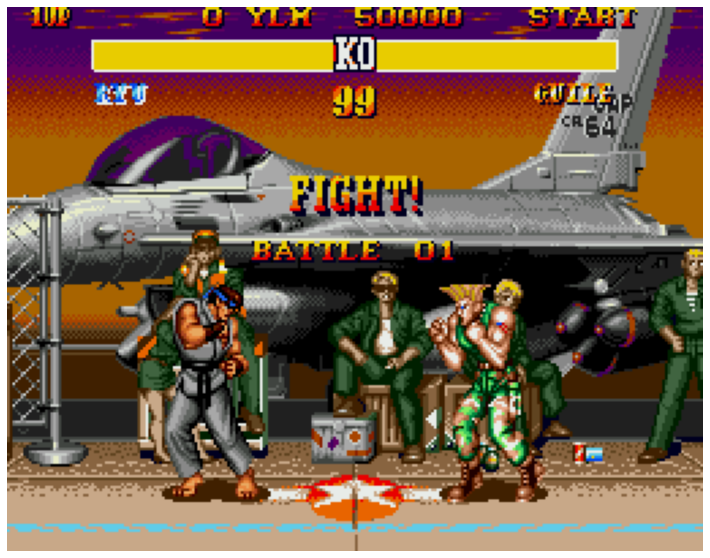

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

observation = env.reset()
for i in range( 100 ): # Take random actions for 100 steps
    random_action = env.action_space.sample()
    observation, reward, done, info = env.step( random_action )
    if done: # If the env is done make sure you reset it
        observation = env.reset()

plt.figure( figsize=( 20, 10 ) )
plt.axis( 'off' )
plt.imshow( observation )

In [ ]:
# gets us data about the simulation of the environment
info 

{'enemy_matches_won': 0,
 'score': 0,
 'matches_won': 0,
 'continuetimer': 0,
 'enemy_health': 176,
 'health': 176}

# Create preprocessing of the environment

In [7]:
from gym import Env
from gym.spaces import MultiBinary, Box
import numpy as np #frame delta
import cv2 #grayscale
from matplotlib import pyplot as plt

In [10]:
#Create custom environment
class StreetFighter(Env):
    def __init__(self):
        super().__init__()
        #action space and obs space
        self.observation_space = Box(low = 0, high = 255, shape = (84,84,1), dtype = np.uint8)
        self.action_space = MultiBinary(12)
        #setup game
        self.game = retro.make(game = 'StreetFighterIISpecialChampionEdition-Genesis',
                               use_restricted_actions = retro.Actions.FILTERED)
    def reset(self):
        #return to first frame
        obs = self.game.reset()
        obs = self.preprocess(obs)
        self.previous_frame = obs
        
        #variable for score delta
        self.score = 0
        return obs
    
    def state_encoder(state):
    # Define the neural network architecture
        model = nn.Sequential([
            nn.Conv(in_channel=1, out_channel=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv(in_channel=32, out_channel=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dense(64*4*4, 64)
    ])
        # Encode the state
        encoded_state = model(state)
        return encoded_state

    def action_encoder(action):
        return action

    def score_encoder(score):
        return score


    def preprocess(self, observation):
        
        #grayscale
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        #reseize
        resize = cv2.resize(gray, (84,84), interpolation = cv2.INTER_CUBIC)
        #Add channels value as our resize doesn't allow us to reshape as an (84,84,1)
        # but as an (84,84)
        channels = np.reshape(resize, (84,84,1))
        # Calculate frame difference
        if self.previous_frame is None:
          frame_diff = np.zeros_like(resize)
        else:
          frame_diff = resize - self.previous_frame

        # Encode state
        state_encoding = self.state_encoder(channels)
        # Encode action
        action_encoding = self.action_encoder(self.action)
        # Encode score
        score_encoding = self.score_encoder(self.score)
        # Concatenate encodings
        concatenated = np.concatenate([state_encoding, action_encoding, score_encoding], axis=-1)
        return concatenated, frame_diff
    
    def step(self,action):
        #take a step to get back 
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs)
        
        #frame delta
        frame_delta = obs - self.previous_frame
        self.previous_frame = obs
        
        reward = info['score'] - self.score
        self.score = info['score']
        return frame_delta, reward, done, info
    
    def render(self, *args, **kargs):
        self.game.render()
    
    def close(self):
        self.game.close()

In [ ]:
env.close()

In [ ]:
env = StreetFighter()

In [ ]:
env.reset()
done = False #
for game in range(1):
    while not done:
        if done:
            obs = env.reset()
        #env.render()
        obs, reward, done, info = env.step(env.action_space.sample())
        if reward > 0:
            print(reward)

Now that the preprocessor is successfull, we need to hyper-tune our reward function.

This is where we start using the DISDAIN agent.

# DISDAIN

Referencing the disdain algorithm from the github repo of 
https://github.com/deepmind/disdain



# Install Jax and CUDA


In [ ]:
# @title (Optional) Install JAX 0.3.10 with CUDA support
#!pip install --upgrade pip
# Installs the wheel compatible with CUDA 11 and cuDNN 8.2 or newer.
!pip install --upgrade "jax[cuda]==0.3.14" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html  # Note: wheels only available on linux.

In [ ]:
#@title Install a more recent matplotlib (may require a runtime restart)
# Fixes the use of tight_layout() with suptitle(...) below
# See https://matplotlib.org/stable/users/prev_whats_new/whats_new_3.3.0.html#tight-layout-now-supports-suptitle
!pip install 'matplotlib==3.5.0'
!pip install 'rlax==0.1.4'

import matplotlib

if tuple(map(int, matplotlib.__version__.split('.')[:2])) < (3, 3):
  raise RuntimeError('Outdated matplotlib detected. '
                     'Restart the runtime before proceeding.')

In [19]:
#@title Imports
import functools
import dataclasses
import datetime
import math
import operator
import sys

import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, nn, random
from jax.experimental import optimizers
import matplotlib.pyplot as plt
from typing import Dict, List, NewType, Optional, Tuple, TypeVar, Union
from typing_extensions import Protocol
try:
  import chex
except ImportError:
  !pip install git+https://github.com/deepmind/chex.git@v0.1.3
  import chex
try:
  import haiku as hk
except ImportError:
  !pip install git+https://github.com/deepmind/dm-haiku.git@v0.0.6
  import haiku as hk
try:
  import optax
except ImportError:
  !pip install git+https://github.com/deepmind/optax.git@v0.1.2
  import optax
try:
  import rlax
except ImportError:
  !pip install git+https://github.com/deepmind/rlax.git@b652c45382605d3bf2c7db837364deda19819fce
  import rlax


try:
  import jax.tools.colab_tpu
  try:
    jax.tools.colab_tpu.setup_tpu()
  except KeyError:  # Not on a TPU Colab backend.
    pass
except ImportError:
  pass

Now that disdain is working and all the packages have been imported, we can start implementing disdain for our Agent.

# JAX Implementation of DISDAIN algorithm
Check mengdi's github:
https://github.com/mengdi-li/disdain-skill-discovery

As there are other aspects that need to be discussed about this implementation.

Due to the very high computational power, as well as JAX modules not being able to install on a native windows installation. We had to move the implementation to google collab to be able to use the GPU properly.

In [8]:
from jax import random

In [22]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [ ]:
from keras.layers import Dense, Reshape, BatchNormalization
from keras.models import Sequential

def generator():
    model = Sequential()
    model.add(Dense(256, input_dim=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(np.prod(self.image_shape), activation='tanh'))
    model.add(Reshape(self.image_shape))
    return model

def discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=input_shape, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [20]:
# Define the generator network
def generator_network(params, concatenated_encodings, frame_delta):
    """
    params: parameters of the generator network
    concatenated_encodings: concatenated encodings of state, action, and score
    frame_delta: difference between current frame and previous frame
    """
    # Define the layers of the generator network
    layers = [nn.Dense(64), nn.Relu, nn.Dense(64), nn.Relu, nn.Dense(1)]
    # Apply the layers to the input data
    output = np.concatenate([concatenated_encodings, frame_delta], axis=-1)
    for layer in layers:
        output = layer(params, output)
    # Generate predicted score
    score_prediction = nn.sigmoid(output)
    return score_prediction

# Define the discriminator network
def discriminator_network(params, concatenated_encodings, actual_score):
    """
    params: parameters of the discriminator network
    concatenated_encodings: concatenated encodings of state, action, and score
    actual_score: actual score obtained by the agent
    """
    # Define the layers of the discriminator network
    layers = [nn.Dense(64), nn.Relu, nn.Dense(64), nn.Relu, nn.Dense(1)]
    # Apply the layers to the input data
    output = np.concatenate([concatenated_encodings, actual_score], axis=-1)
    for layer in layers:
        output = layer(params, output)
    # Generate probability of actual score
    score_probability = nn.sigmoid(output)
    return score_probability

# Define the loss function for the generator network
def generator_loss(params, generator_output, discriminator_output):
    return -np.mean(discriminator_output)

# Define the loss function for the discriminator network
def discriminator_loss(params, actual_score, discriminator_output):
    return np.mean(nn.binary_cross_entropy(actual_score, discriminator_output))

In [21]:
def test_hyperparameters():
    return {
        'lr_gen': 0.0001, # learning rate for the generator
        'lr_dis': 0.0001, # learning rate for the discriminator
        'beta1': 0.5, # beta1 parameter for Adam optimizer
        'beta2': 0.9, # beta2 parameter for Adam optimizer
        'batch_size': 64, # batch size for training
        'num_epochs': 100 # number of training epochs
    }

def objective_function(gen_params, dis_params,concatenated_encodings, hyperparams, score, frame_delta):
    """
    gen_params: parameters of the generator network
    dis_params: parameters of the discriminator network
    state: current state of the game
    action: action taken by the agent
    score: score obtained by the agent
    """
    # define the generator and discriminator networks
    generator = generator_network(gen_params, concatenated_encodings, frame_delta)
    discriminator1 = discriminator_network(dis_params, concatenated_encodings, score)
    #discriminator2 = discriminator_network(dis_params,, concatenated_encodings, score)
    
    # generate samples from the generator
    generated_data = generator(gen_params, state, action)
    
    # compute the loss for the generator and discriminator
    gen_loss = generator_loss(gen_params, generator, discriminator1)
    dis_loss = discriminator_loss(dis_params,score, discriminator1)
    
    # compute the gradients for the generator and discriminator
    gen_grad = grad(gen_loss, gen_params)
    dis_grad = grad(dis_loss, dis_params)
    
    # return the losses and gradients
    return gen_loss, dis_loss, gen_grad, dis_grad

# compile the objective function for faster execution
objective_function = jit(objective_function)


def train_step(gen_params, dis_params, generator_network, discriminator_network, concatenated_encodings, frame_delta, reward):
    """
    gen_params: parameters of the generator network
    dis_params: parameters of the discriminator network
    generator_network: generator network function
    discriminator_network: discriminator network function
    concatenated_encodings: concatenated encodings of state, action, and score
    frame_delta: difference between current frame and previous frame
    reward: reward obtained by the agent
    """

    # Generate samples from the generator
    generated_score = generator_network(gen_params, concatenated_encodings, frame_delta)

    # Compute the loss for the generator and discriminator
    gen_loss = generator_loss(gen_params, generated_score, discriminator_network(dis_params, concatenated_encodings, generated_score))
    dis_loss = discriminator_loss(dis_params, reward, discriminator_network(dis_params, concatenated_encodings, reward))

    # Compute the gradients for the generator and discriminator
    gen_grad = grad(gen_loss, gen_params)
    dis_grad = grad(dis_loss, dis_params)
    
    # update the generator and discriminator parameters
    gen_params = optimizers.Adam(learning_rate=0.0001).update(gen_params, gen_grad)
    dis_params = optimizers.Adam(learning_rate=0.0001).update(dis_params, dis_grad)

    return gen_params, dis_params, gen_loss, dis_loss


In [23]:
def main(params, num_steps):
    # Initialize the generator and discriminator parameters
    gen_params = generator_network.init(rng, (64,))
    dis_params = discriminator_network.init(rng, (64,))

    # Initialize the game
    game = StreetFighter2()
    # Initialize the previous frame variable
    previous_frame = None
    # Initialize the score variable
    score = 0
    # Initialize the optimizer
    optimizer = optimizers.Adam(learning_rate=1e-4)
    for step in range(num_steps):
        # Get the concatenated encodings and frame delta
        concatenated_encodings, frame_delta = game.preprocess(game.observation)
        # Take a step in the game
        frame_delta, reward, done, info = game.step(game.action)
        # Train the networks
        gen_params, dis_params = train_step(gen_params, dis_params, generator_network, discriminator_network, concatenated_encodings, frame_delta, reward)
        # Update the previous frame variable
        previous_frame = frame_delta
        # Update the score variable
        score = info['score']
        # Check if the game is done
        if done:
            # Reset the game
            game.reset()
            # Reset the previous frame variable
            previous_frame = None
            # Reset the score parameter
            score = 0

In [ ]:
# Define the input shape
input_shape = (84, 84, 1)

# Define the number of discriminators
num_discriminators = 3

# Generate the random number generator key
rng = random.PRNGKey(0)

# Create the generator and discriminator models
generator_model = generator()
discriminator_model = discriminator()

# Compile the generator and discriminator models
generator_model.compile(loss='binary_crossentropy', optimizer='adam')
discriminator_model.compile(loss='binary_crossentropy', optimizer='adam')

# Implementation using Hyperparameters as an alternative to the DISDAIN implementation

This other solution offers a good starting understanding of an alternative solution using PyTorch and Stable Baseline3 instead of using JAX so it can run entirely on a windows machine and not via Google Colab.
!!! Needs to be tested !!!

In [ ]:
!pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
!pip install stable-baselines3[extra] optuna

In [ ]:
# Importing the optimzation frame - HPO
import optuna
# PPO algo for RL
from stable_baselines3 import PPO
# Bring in the eval policy method for metric calculation
from stable_baselines3.common.evaluation import evaluate_policy
# Import the sb3 monitor for logging 
from stable_baselines3.common.monitor import Monitor
# Import the vec wrappers to vectorize and frame stack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
# Import os to deal with filepaths
import os

In [ ]:

LOG_DIR = './logs/'
OPT_DIR = './opt/'

In [ ]:
# Function to return test hyperparameters - define the object function
def optimize_ppo(trial): 
    return {
        'n_steps':trial.suggest_int('n_steps', 2048, 8192),
        'gamma':trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
        'clip_range':trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda':trial.suggest_uniform('gae_lambda', 0.8, 0.99)
    }

In [ ]:
SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(1))

In [ ]:
# Run a training loop and return mean reward 
def optimize_agent(trial):
    try:
        model_params = optimize_ppo(trial) 

        # Create environment 
        env = StreetFighter()
        env = Monitor(env, LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env, 4, channels_order='last')

        # Create algo 
        model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=0, **model_params)
        model.learn(total_timesteps=30000)
        #model.learn(total_timesteps=100000)

        # Evaluate model 
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()

        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)

        return mean_reward

    except Exception as e:
        return -1000

In [ ]:
# Creating the experiment 
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=10, n_jobs=1)
#study.optimize(optimize_agent, n_trials=100, n_jobs=1)

In [ ]:
study.best_params


In [ ]:
study.best_trial

In [ ]:

model = PPO.load(os.path.join(OPT_DIR, 'trial_5_best_model.zip'))